# コード3-2：各種回帰モデルの実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

一般化線形モデルの実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

- `MASS`パッケージの`glm.nb()`関数のR Documentation  
https://www.rdocumentation.org/packages/MASS/versions/7.3-60.0.1/topics/glm.nb

In [1]:
## 必要があればインストール
# install.packages(c("ggplot2", "patchwork", "MASS"))

In [2]:
rm(list = ls(all = TRUE))
library(MASS)
library(ggplot2)
library(patchwork)


Attaching package: ‘patchwork’


The following object is masked from ‘package:MASS’:

    area




## 一般化線形モデル

数学コラム０２で言及された一般化線形モデルのうち以下の実装を紹介する。

- ポアソン回帰
- 正規分布に基づく回帰
- 負の二項分布に基づく回帰

Rの`stats`ライブラリにある`glm`関数と`MASS`パッケージの`glm.nb`関数を用いる

- https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm
- https://www.rdocumentation.org/packages/MASS/versions/7.3-60.0.1/topics/glm.nb

## ポアソン回帰

データ$y_i$、説明変数$x_i={0, 1,..., 99, 100}$で、誤差構造を

$$
P(y_i = k | \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$

と考える。ポアソン分布の母数$\lambda$について線形予測子を用いて

$$
\psi \left( \lambda \right) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

と表し、リンク関数$\psi$を対数関数とすることで、回帰を行う。

In [3]:
set.seed(5432) ## 乱数のシード値
nobs1 <- 100 ## データの数
x <- runif(n = nobs1, min = 0, max = 100) ## 説明変数
lny <- rpois(n = nobs1, lambda = exp(-(.03*x + .0001*x**2 - 1.0))) ## ポアソン分布からランダムサンプリング

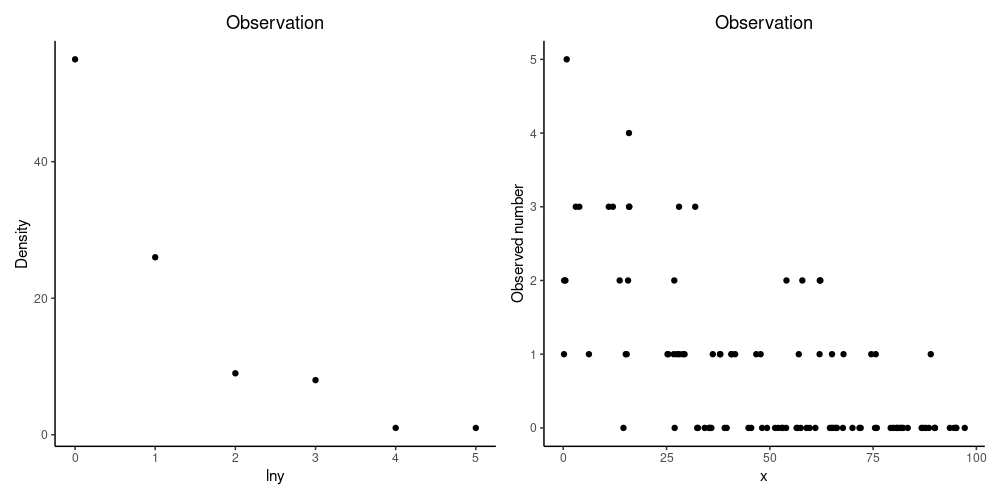

In [4]:
## データのプロット

p1 <- ggplot(data = data.frame(x = as.numeric(names(table(lny))),
                               y = as.numeric(table(lny))),
             aes(x = x, y = y)) +
    geom_point() +
    xlab("lny") +
    ylab("Density") +
    labs(title = "Observation") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

p2 <- ggplot(data = data.frame(x = x, y = lny), aes(x = x, y = y)) +
    geom_point() +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

In [5]:
## 誤差構造：ポアソン分布 / リンク関数：対数 / 線形予測子：beta_0 + beta_1*x^2 + beta_2*x^2
data_poisson <- data.frame(x1 = x, x2 = x^2, y = lny)
poisson_log <- glm(y ~ x1 + x2, data = data_poisson, family = poisson(link = "log"))
summary(poisson_log)


Call:
glm(formula = y ~ x1 + x2, family = poisson(link = "log"), data = data_poisson)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.049e+00  2.258e-01   4.646 3.39e-06 ***
x1          -3.134e-02  1.492e-02  -2.101   0.0356 *  
x2          -6.058e-05  1.958e-04  -0.309   0.7570    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 145.122  on 99  degrees of freedom
Residual deviance:  84.332  on 97  degrees of freedom
AIC: 196.54

Number of Fisher Scoring iterations: 6


In [6]:
estpars <- poisson_log[["coefficients"]]

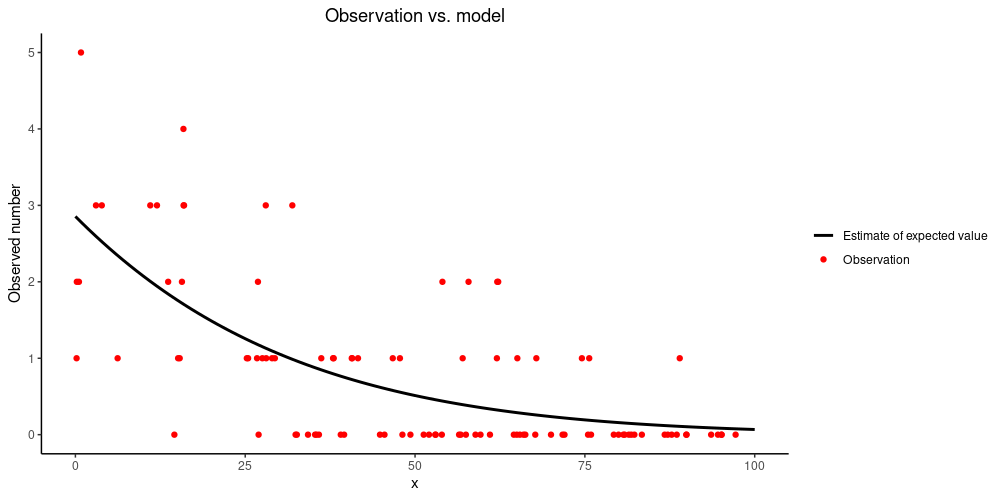

In [7]:
## 結果のプロット
x_fit <- 0:100
data_plot <- rbind(data.frame(x = x,
                              y = lny,
                              label = "obs"),
                   data.frame(x = x_fit,
                              y = exp(estpars[2]*x_fit + estpars[3]*x_fit**2 + estpars[1]),
                              label = "fit"))

data_plot$label <- factor(data_plot$label, levels = c("fit", "obs"))

ggplot(data = data_plot, aes(x = x, y = y)) +
    geom_line(aes(linewidth = label), color = "black") +
    geom_point(aes(color = label)) +
    scale_color_manual(values = c(obs = "red", fit = "#ffffff00"),
                       label = c(obs = "Observation", fit = "Estimate of expected value")) +
    scale_linewidth_manual(values = c(obs = 0, fit = 1),
                           label = c(obs = "Observation", fit = "Estimate of expected value")) +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation vs. model") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank())

# 正規分布に基づく回帰

データ$y_i$、説明変数$x_i={0, 1,..., 99, 100}$で、誤差構造を

$$
P(y_i | \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left( - \frac{(y_i - \mu)^2}{2\sigma^2} \right)
$$

と考える。正規分布の平均$\mu$について線形予測子を用いて

$$
\psi \left( \mu \right) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

と表し、リンク関数$\psi$を対数関数とすることで、回帰を行う。

In [8]:
set.seed(5432) ## 乱数のシード値
nobs2 <- 100 ## データの数
x <- runif(n = nobs2, min = 0, max = 100) ## 説明変数
lny <- rnorm(n = nobs1, mean = exp(-(.03*x + .0001*x**2 - 1.0)), sd = 0.15) ## 正規分布からランダムサンプリング

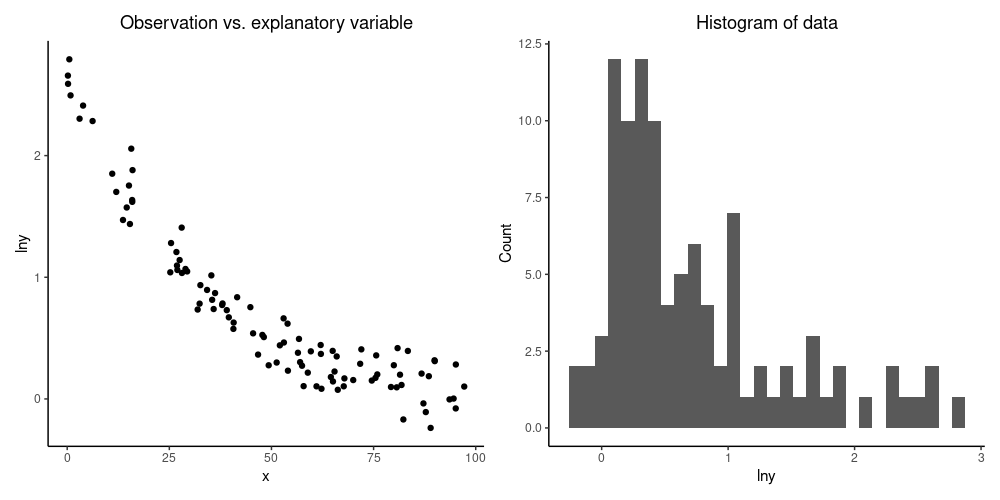

In [9]:
## データのプロット

p1 <- ggplot(data = data.frame(x = x, y = lny), aes(x = x, y = y)) +
    geom_point() +
    xlab("x") +
    ylab("lny") +
    labs(title = "Observation vs. explanatory variable") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

p2 <- ggplot(data = data.frame(x = lny), aes(x = x)) +
    geom_histogram(bins = 30) +
    xlab("lny") +
    ylab("Count") +
    labs(title = "Histogram of data") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

In [10]:
## 誤差構造：ガウス分布（正規分布） / リンク関数：対数 / 線形予測子：beta_0 + beta_1*x^2 + beta_2*x^2
data_gauss <- data.frame(x1 = x, x2 = x^2, y = lny)
gauss_log <- glm(y ~ x1 + x2, data = data_gauss, family = gaussian(link = "log"),
                 start = c(1, 0.01, 0.001))
summary(gauss_log)


Call:
glm(formula = y ~ x1 + x2, family = gaussian(link = "log"), data = data_gauss, 
    start = c(1, 0.01, 0.001))

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.764e-01  2.388e-02  40.894   <2e-16 ***
x1          -2.924e-02  2.420e-03 -12.083   <2e-16 ***
x2          -1.018e-04  4.566e-05  -2.229   0.0281 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.02178335)

    Null deviance: 49.559  on 99  degrees of freedom
Residual deviance:  2.113  on 97  degrees of freedom
AIC: -93.92

Number of Fisher Scoring iterations: 18


In [11]:
estpars <- gauss_log[["coefficients"]]

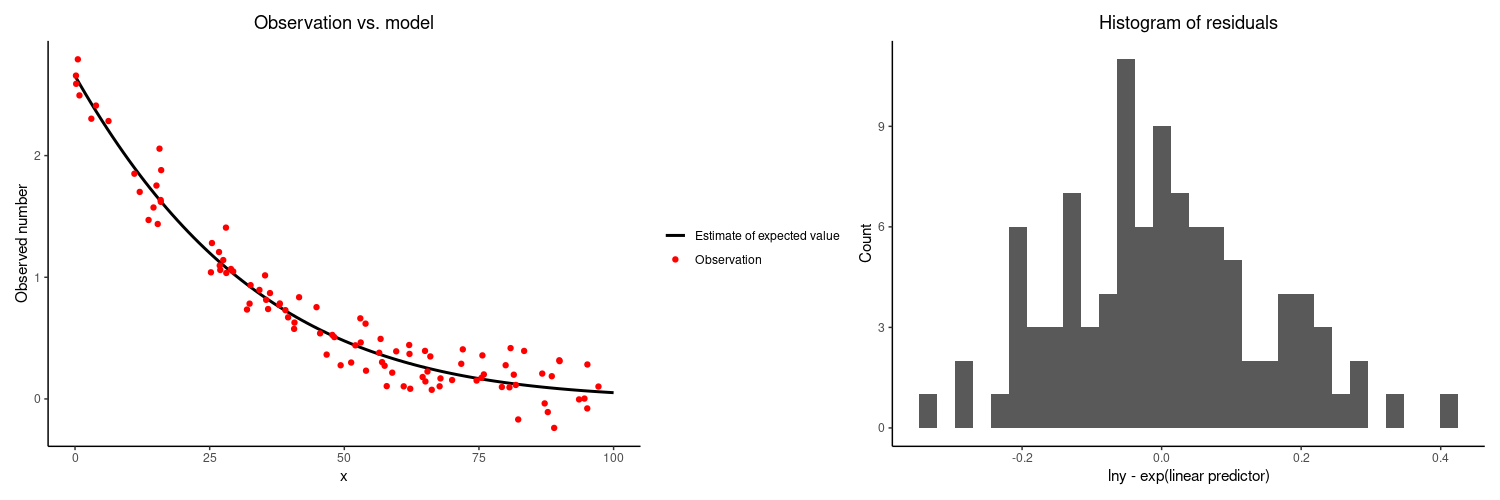

In [12]:
## 結果のプロット
x_fit <- 0:100
data_plot <- rbind(data.frame(x = x,
                              y = lny,
                              label = "obs"),
                   data.frame(x = x_fit,
                              y = exp(estpars[2]*x_fit + estpars[3]*x_fit**2 + estpars[1]),
                              label = "fit"))

data_plot$label <- factor(data_plot$label, levels = c("fit", "obs"))

p1 <- ggplot(data = data_plot, aes(x = x, y = y)) +
    geom_line(aes(linewidth = label), color = "black") +
    geom_point(aes(color = label)) +
    scale_color_manual(values = c(obs = "red", fit = "#ffffff00"),
                       label = c(obs = "Observation", fit = "Estimate of expected value")) +
    scale_linewidth_manual(values = c(obs = 0, fit = 1),
                           label = c(obs = "Observation", fit = "Estimate of expected value")) +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation vs. model") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank())

p2 <- ggplot(data = data.frame(x = lny - exp(estpars[2]*x + estpars[3]*x**2 + estpars[1])),
             aes(x = x)) +
    geom_histogram(bins = 30) +
    xlab("lny - exp(linear predictor)") +
    ylab("Count") +
    labs(title = "Histogram of residuals") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank())

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

## 負の二項分布に基づく回帰（追記予定）

データ$y_i$、説明変数$x_i={0, 1,..., 99, 100}$で、誤差構造を

$$
P(y_i = k | r, p) = \begin{pmatrix} k + r - 1 \\ r - 1 \end{pmatrix} (1-p)^r p^k 
$$

と考える。ここで期待値は

$$
E[y_i]=\frac{rp}{1-p}
$$

分散は

$$
Var[y_i] = \frac{rp}{(1-p)^2}
$$

と表される。

平均を$\mu = E[y_i]$として、分散は新規パラメータ$\theta = \frac{{\mu}^2}{Var[y_i] - \mu}$を用いて

$$
Var[y_i] = \mu + \frac{{\mu}^2}{\theta}
$$

と表すこととする。

正規分布の母数$\mu$について線形予測子を用いて

$$
\psi \left( \mu \right) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

と表し、リンク関数$\psi$を対数関数とすることで、回帰を行う。

`MASS`パッケージの`glm.nb()`関数を用いる。

In [13]:
set.seed(5432) ## 乱数のシード値
nobs3 <- 100 ## データの数
x <- runif(n = nobs3, min = 0, max = 100) ## 説明変数
lny <- rnbinom(n = nobs3, size = 10, mu = exp(-(.03*x + .0001*x**2 - 1.0))) ## 負の二項分布からランダムサンプリング

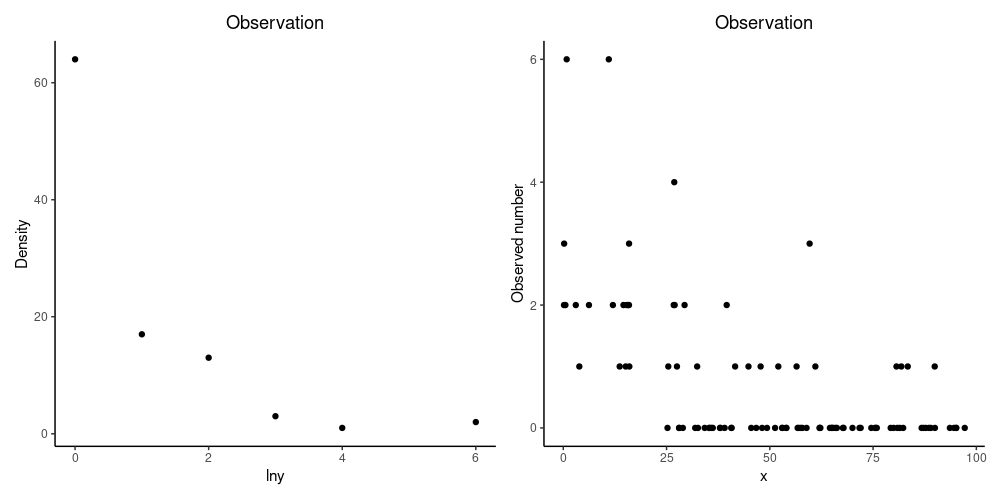

In [14]:
## データのプロット

p1 <- ggplot(data = data.frame(x = as.numeric(names(table(lny))),
                               y = as.numeric(table(lny))),
             aes(x = x, y = y)) +
    geom_point() +
    xlab("lny") +
    ylab("Density") +
    labs(title = "Observation") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

p2 <- ggplot(data = data.frame(x = x, y = lny), aes(x = x, y = y)) +
    geom_point() +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

In [15]:
## 誤差構造：負の二項分布 / リンク関数：対数 / 線形予測子：beta_0 + beta_1*x^2 + beta_2*x^2
data_poisson <- data.frame(x1 = x, x2 = x^2, y = lny)
ngbinom_log <- glm.nb(y ~ x1 + x2, data = data_poisson)
summary(ngbinom_log)


Call:
glm.nb(formula = y ~ x1 + x2, data = data_poisson, init.theta = 14.95823065, 
    link = log)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.2802314  0.2311181   5.539 3.04e-08 ***
x1          -0.0576655  0.0160599  -3.591  0.00033 ***
x2           0.0002097  0.0002077   1.010  0.31259    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(14.9582) family taken to be 1)

    Null deviance: 154.009  on 99  degrees of freedom
Residual deviance:  84.995  on 97  degrees of freedom
AIC: 184.76

Number of Fisher Scoring iterations: 1


              Theta:  15.0 
          Std. Err.:  35.1 

 2 x log-likelihood:  -176.764 

In [16]:
estpars <- ngbinom_log[["coefficients"]]

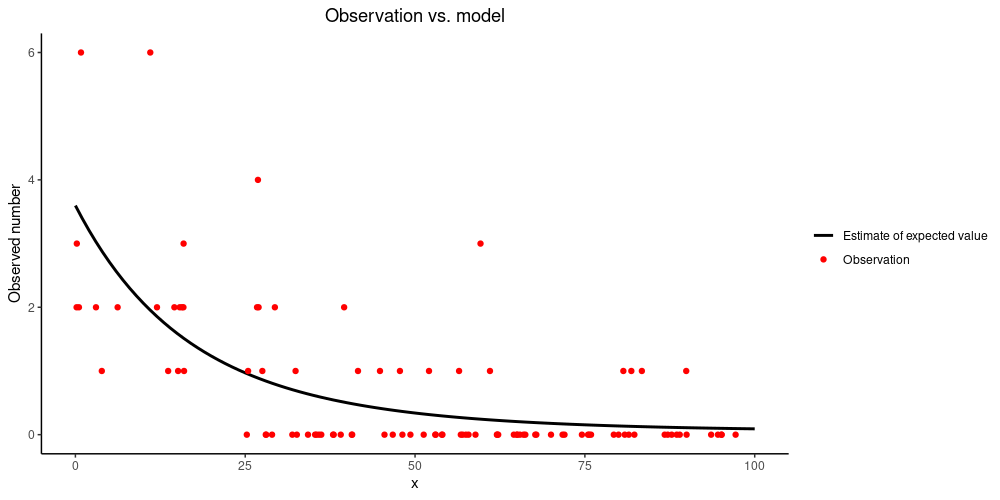

In [17]:
## 結果のプロット
x_fit <- 0:100
data_plot <- rbind(data.frame(x = x,
                              y = lny,
                              label = "obs"),
                   data.frame(x = x_fit,
                              y = exp(estpars[2]*x_fit + estpars[3]*x_fit**2 + estpars[1]),
                              label = "fit"))

data_plot$label <- factor(data_plot$label, levels = c("fit", "obs"))

ggplot(data = data_plot, aes(x = x, y = y)) +
    geom_line(aes(linewidth = label), color = "black") +
    geom_point(aes(color = label)) +
    scale_color_manual(values = c(obs = "red", fit = "#ffffff00"),
                       label = c(obs = "Observation", fit = "Estimate of expected value")) +
    scale_linewidth_manual(values = c(obs = 0, fit = 1),
                           label = c(obs = "Observation", fit = "Estimate of expected value")) +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation vs. model") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank())